In [1]:
# project: Capstone: Netflix Titles
# submitter: hweld
# partner: none
# hours: 50

In [2]:
import pandas as pd    
from pandas import Series, DataFrame
import csv
import matplotlib
from matplotlib import pyplot
import sqlite3

%matplotlib inline

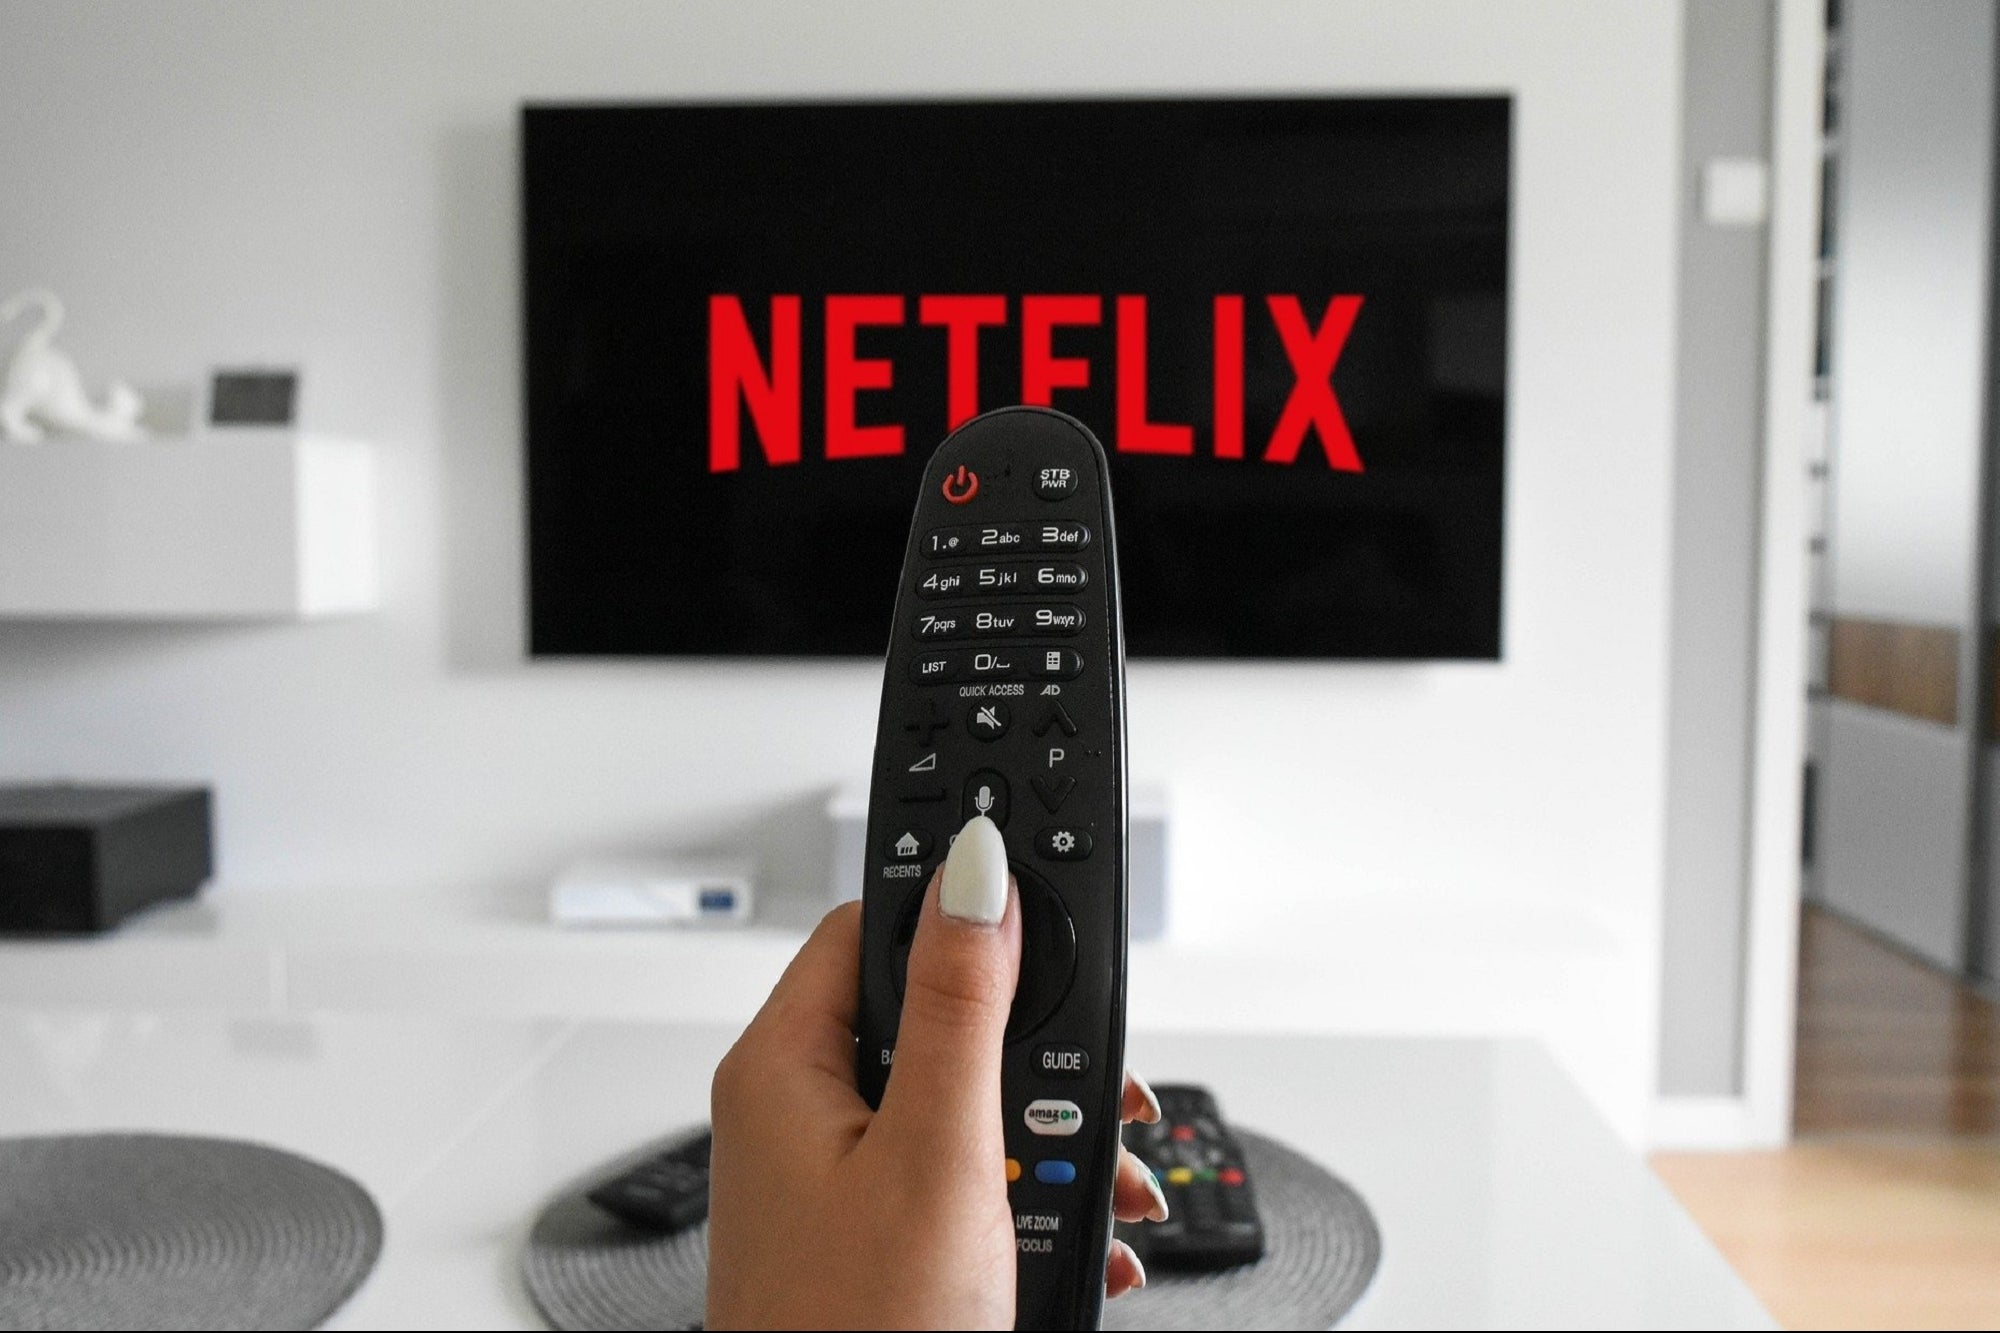

In [3]:
#Read in CSV file containing netflix titles
#Dataset obtained from https://www.kaggle.com/shivamb/netflix-shows and updated on 2021/01/18
netflix = pd.read_csv("netflix_titles.csv") 

In [4]:
#Data clean up null values
netflix.isnull().sum()

netflix.loc[netflix["country"].isnull(),"country"] = "Unknown"
netflix.loc[netflix["director"].isnull(),"director"] = "Unknown"
netflix.loc[netflix["cast"].isnull(),"cast"] = "Unknown"
netflix.loc[netflix["rating"].isnull(),"rating"] = "NR" #NR for Not Rated which is a rating category already available

In [5]:
#Data prep

#Helper Functions
def filter_by(df,column,filter_by_value):
    '''Returns a dataframe filtered by given column and value'''
    return df[df[column] == filter_by_value]

def exclude_by(df,column,exclude_by_column):
    '''Returns a dataframe which excludes a value by given column and value'''
    return df[df[column] != exclude_by_column]

def filter_by_value_contained_in(df,column,value):
    '''Returns a dataframe filtered by given column where the given value can appear anywhere in the column'''
    return df[df[column].str.contains(value)]

def exclude_by_value_contained_in(df,column,value):
    '''Returns a dataframe which excludes the column value of given column where the value can appear anywhere in the column'''
    return df[~df[column].str.contains(value)]

#The column for countries often contains a list of countries - creating a second column with the first country listed
netflix['country_primary'] = netflix['country'].apply(lambda x: x.split(",")[0])
netflix.loc[netflix["country_primary"] == "West Germany","country_primary"] = "Germany"
netflix.loc[netflix["country_primary"] == "Soviet Union","country_primary"] = "Russia"

#Split into 2 Dataframes for Movies and TV Shows
netflix_Movies = filter_by(netflix,"type","Movie")
netflix_TV = filter_by(netflix,"type","TV Show")
print("Number of Unique Movies Titles: ", len(set(netflix_Movies["title"])))
print("Num of of Unique TV Show Titles: ", len(set(netflix_TV["title"])))
print("Total Number of Unique Titles: ", len(set(netflix["title"])))

#Create new numeric column for Number of Seasons
netflix_TV = netflix_TV.copy() #This is to avoid the SettingWithCopyWarning
netflix_TV['NumSeasons'] = pd.to_numeric(netflix_TV['duration'].str.rstrip(' Seasons'))

#Create new runtime column for duration in minutes
netflix_Movies = netflix_Movies.copy() #This is to avoid the SettingWithCopyWarning
netflix_Movies['runtime'] = pd.to_numeric(netflix_Movies['duration'].str.rstrip(' min'))

#Create Dataframes by country & type
Netflix_US = filter_by_value_contained_in(netflix,"country","United States")
Netflix_outside_US = exclude_by_value_contained_in(netflix,"country","United States")

Netflix_US_Movies = filter_by_value_contained_in(netflix_Movies,"country","United States")
Netflix_US_TV = filter_by_value_contained_in(netflix_TV,"country","United States")
Netflix_outside_US_Movies = exclude_by_value_contained_in(netflix_Movies,"country","United States")
India_Movies = filter_by_value_contained_in(netflix_Movies,"country","India")

#Convert to SQL lite DB
conn = sqlite3.connect('neflix.db')
netflix.to_sql("netflix", conn, if_exists="replace", index=False)

Number of Unique Movies Titles:  5377
Num of of Unique TV Show Titles:  2410
Total Number of Unique Titles:  7787


In [6]:
#Exploring the Netflix dataset for specific contents - Helpful for testing and general questions

def search_netflix(column, column_value):
    '''Searches the netflix dataframe for values anywhere in a column and returns a dataframe with relevant content details'''
    result = netflix[netflix[column].str.contains("(?i)" + column_value)] #The regedit expression allows for case insenstive matches
    if len(result) == 0:
        return "Sorry, no content for " + column + " currently not on Netflix"
    return result[["title","type","director","cast","country","date_added","release_year","rating","listed_in","description"]].reset_index(drop=True)
    

search_netflix("director", "Hitchcock")

'Sorry, no content for director currently not on Netflix'

In [7]:
search_netflix("title", "Mary Poppins")

,title,type,director,cast,country,date_added,release_year,rating,listed_in,description
0,Mary Poppins Returns,Movie,Rob Marshall,"Emily Blunt, Lin-Manuel Miranda, Ben Whishaw, ...","United States, United Kingdom","July 9, 2019",2018,PG,"Children & Family Movies, Music & Musicals","In 1930s London, Michael Banks and his three c..."


In [8]:
search_netflix("country", "North Korea")

'Sorry, no content for country currently not on Netflix'

In [9]:
search_netflix("cast", "Chris Hemsworth")

,title,type,director,cast,country,date_added,release_year,rating,listed_in,description
0,Avengers: Infinity War,Movie,"Anthony Russo, Joe Russo","Robert Downey Jr., Josh Brolin, Mark Ruffalo, ...",United States,"December 25, 2018",2018,PG-13,"Action & Adventure, Sci-Fi & Fantasy",Superheroes amass to stop intergalactic sociop...
1,Extraction,Movie,Sam Hargrave,"Chris Hemsworth, Rudhraksh Jaiswal, Randeep Ho...",United States,"April 24, 2020",2020,R,Action & Adventure,A hardened mercenary's mission becomes a soul-...
2,Thor: Ragnarok,Movie,Taika Waititi,"Chris Hemsworth, Tom Hiddleston, Cate Blanchet...",United States,"June 5, 2018",2017,PG-13,"Action & Adventure, Comedies, Sci-Fi & Fantasy",To save Asgard from a bloodthirsty goddess of ...


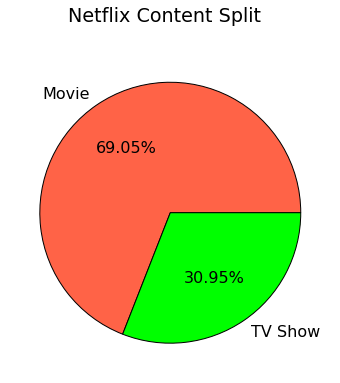

In [10]:
# Q1 How does the Neflix content split into Movies and TV Shows

netflix_type = netflix['type'].value_counts()

matplotlib.rcParams["font.size"] = 16
netflix_type.plot.pie(subplots=True, legend=None, title="Netflix Content Split",ylabel="",figsize=(6, 6),autopct='%1.2f%%',colors=['tomato','lime'],wedgeprops={"edgecolor":"k",'linewidth': 1})
None

###  The majority of the Netflix content are Movies with TV Shows making up for less than a third of the titles.

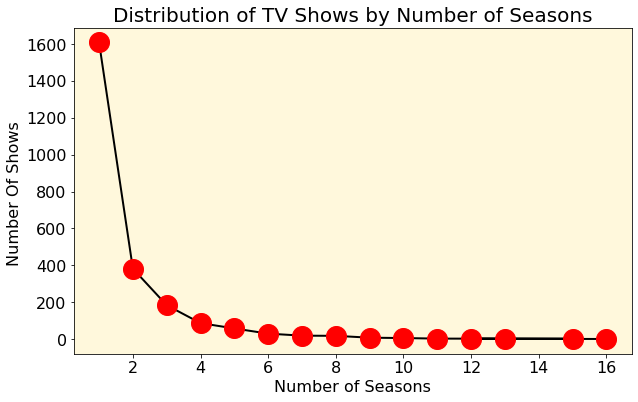

In [11]:
# Q2(a) What is the distribution of TV shows with respect to the number of seasons?

seasons = netflix_TV["NumSeasons"].value_counts()

axes = seasons.plot.line(x = "NumSeasons",y="TV Show Count",legend = False,marker="o",markerfacecolor="red",markeredgecolor="red",markersize=20,linewidth=2,color="black",figsize=(10, 6))
axes.set_ylabel("Number Of Shows ")
axes.set_xlabel("Number of Seasons")
axes.set_title('Distribution of TV Shows by Number of Seasons', fontsize = 20)
axes.set_facecolor("cornsilk")
None

In [12]:
# Q2(b) What is the average number of season for each show? 

round(netflix_TV["NumSeasons"].mean(),2)

1.78

###  While Netflix contains an average of 1.78 seasons for a show, that number could go up to 16 seasons. 

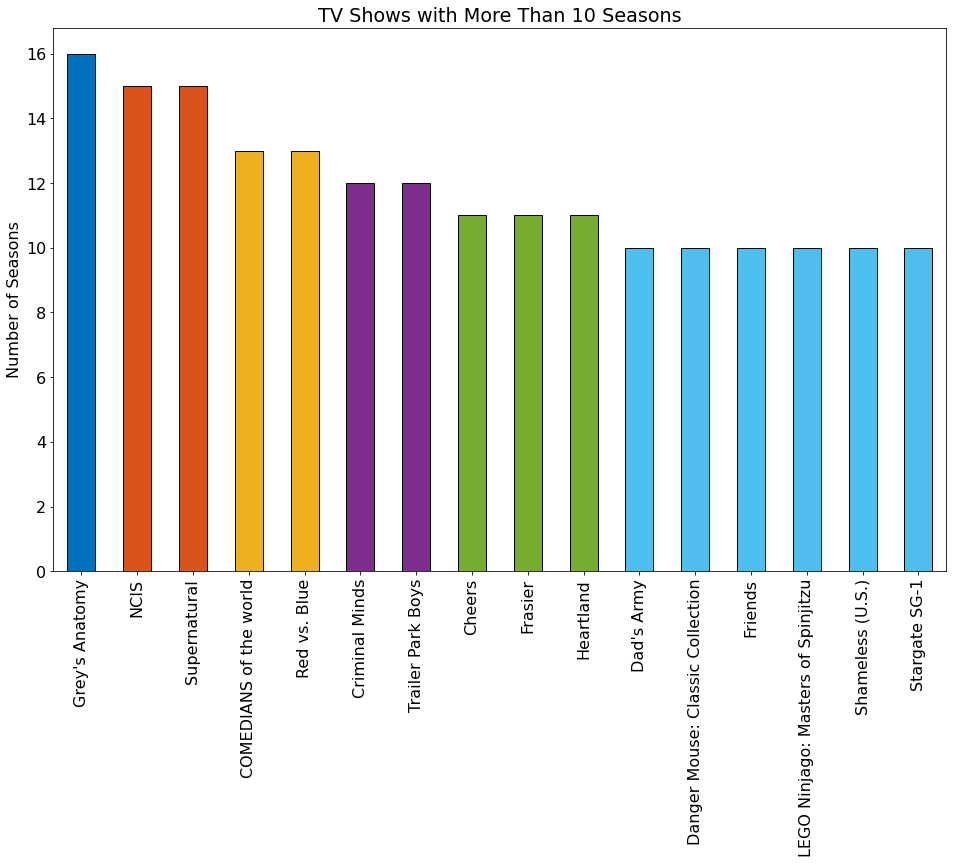

In [13]:
# Q3 What are the shows that have more than 10 seasons?

def create_color_list(integer_list,color_list):
    '''This function takes an integer list and a color list and creates a final list repeating the color list based 
    on the integer value. Every integer will get a different color, until the colors run out.'''
    final_color_list = []
    color_list_index = 0
    for i in range(len(integer_list)):
        for instance in range(integer_list[i]):
            final_color_list.append(color_list[color_list_index])
        if color_list_index < (len(color_list) -1):
            color_list_index = color_list_index + 1
    return final_color_list

netflix_TV_seasons_over_10 = netflix_TV[netflix_TV["NumSeasons"] > 9][["title","NumSeasons"]].sort_values('NumSeasons')

frequency_list = list(netflix_TV_seasons_over_10["NumSeasons"].value_counts().sort_index(ascending=False))

color_list = ['#0072BD','#D95319','#EDB120','#7E2F8E','#77AC30','#4DBEEE']
#Color references are from https://www.mathworks.com/help/matlab/ref/bar.html

color_seasons = create_color_list(frequency_list,color_list)

axes = netflix_TV_seasons_over_10.sort_values(by=['NumSeasons'], ascending=False).plot.bar(x = "title",y="NumSeasons",color=color_seasons,edgecolor="black",figsize=(16, 10))
axes.set_ylabel("Number of Seasons")
axes.set_xlabel("")
axes.get_legend().remove()
axes.set_title('TV Shows with More Than 10 Seasons')
None



###  As of January 2021, Grey's Anatomy with 16 seasons is the show with the most seasons. However, 15 other shows have 10 or more seasons. That's a lot of episodes!

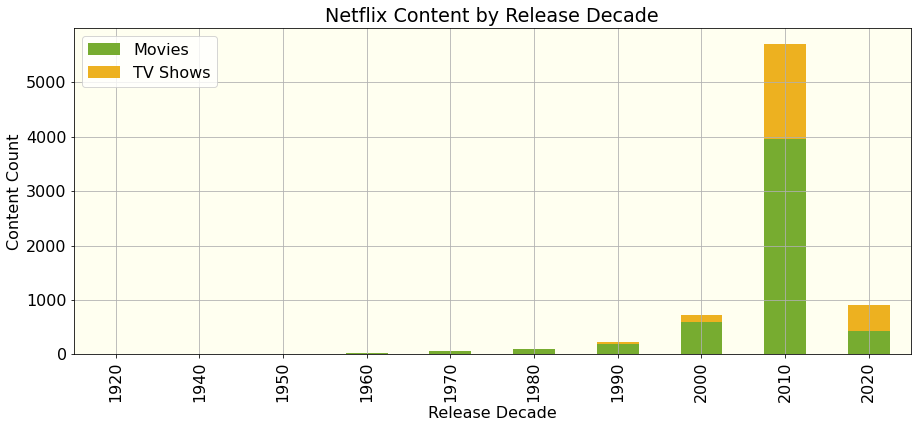

In [14]:
# Q4 What are the content distribution by decade for movies and TV shows?

query = '''
    select cast(release_year/10 as int)*10 as decade, type, count(*) as "Content Count"
    from netflix
    group by decade, type
    order by decade, type'''
netflix_release_decade_count = pd.read_sql(query, conn)

netflix_release_decade_count = netflix_release_decade_count.set_index("decade")
netflix_release_decade_movie = netflix_release_decade_count[netflix_release_decade_count["type"] == "Movie"]["Content Count"]
netflix_release_decade_tv = netflix_release_decade_count[netflix_release_decade_count["type"] == "TV Show"]["Content Count"]

netflix_release_decade = DataFrame({"Movies": netflix_release_decade_movie, "TV Shows": netflix_release_decade_tv})

axes = netflix_release_decade.plot.bar(stacked=True,figsize=(15, 6),color={"Movies": "#77AC30", "TV Shows": "#EDB120"})
axes.set_ylabel("Content Count")
axes.set_xlabel("Release Decade")
axes.set_title('Netflix Content by Release Decade')
axes.set_facecolor("ivory")
axes.grid()
None

###  A majority of the Netflix content is from after 2000 with the decade starting 2010 showing the biggest growth. TV shows have also had had significant growth since 2010 and in 2020 Movies and TV shows seem to be split evenly. TV shows may well take the lead over movies by 2029.

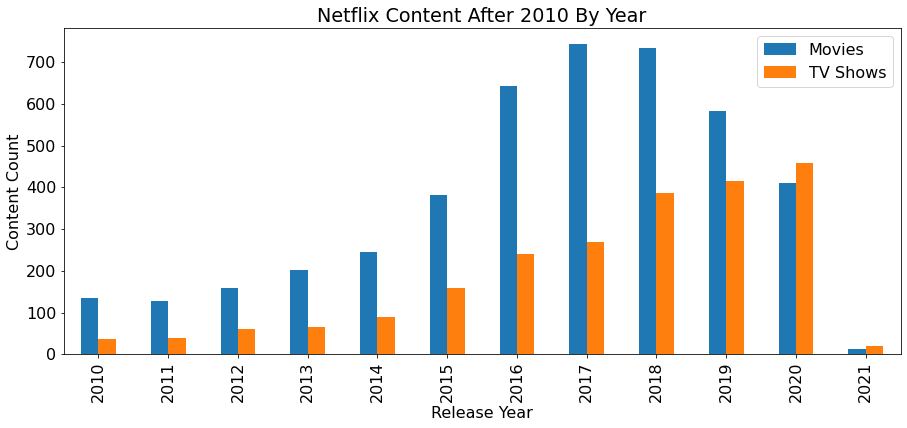

In [15]:
# Q5 Look closer that the growth of content in the last decade. What does that growth look like? 

query = '''
    select release_year, type, count(*) as "Content Count"
    from netflix
    group by release_year, type
    having release_year >= 2010
    order by release_year, type'''
netflix_release_year_count = pd.read_sql(query, conn)

netflix_release_year_count = netflix_release_year_count.set_index("release_year")
netflix_release_year_movie = netflix_release_year_count[netflix_release_year_count["type"] == "Movie"]["Content Count"]
netflix_release_year_tv = netflix_release_year_count[netflix_release_year_count["type"] == "TV Show"]["Content Count"]

netflix_release_year = DataFrame({"Movies": netflix_release_year_movie, "TV Shows": netflix_release_year_tv})

axes = netflix_release_year.plot.bar(figsize=(15, 6))
axes.set_ylabel("Content Count")
axes.set_xlabel("Release Year")
axes.set_title('Netflix Content After 2010 By Year')
None

###  Closer inspection makes it official. More TV shows than Movies in 2020. That could be due to Covid19, but we'll have to see if the consumer preference is changing over the longer term. 

In [16]:
# Q6 What are the 5 oldest movies on Netflix?

def titles_based_on_sort_order(df, column, num_of_values,order_asc=True):
    '''Returns dataframe with titles and column based on input column and number of values specified in the given sort order'''
    new_df = df.sort_values(column, ascending = order_asc)
    return new_df[["title",column]][:num_of_values].reset_index(drop=True)

titles_based_on_sort_order(netflix_Movies,"release_year",5,True)

,title,release_year
0,Prelude to War,1942
1,The Battle of Midway,1942
2,Why We Fight: The Battle of Russia,1943
3,Undercover: How to Operate Behind Enemy Lines,1943
4,WWII: Report from the Aleutians,1943


In [17]:
# Q7 What are the 5 oldest TV Shows on Netflix?

titles_based_on_sort_order(netflix_TV,"release_year",5,True)

,title,release_year
0,Pioneers: First Women Filmmakers*,1925
1,Pioneers of African-American Cinema,1946
2,The Twilight Zone (Original Series),1963
3,The Andy Griffith Show,1967
4,Star Trek,1968


###  The oldest TV show on Netflix seems to predate the oldest movie. Upon closer inspection the oldest TV shows were compiled more recently making "The Twilight Zone" released in 1963 the oldest TV show currently on Netflix. 

In [18]:
# Q8 How many unique countries does the Netflix collection span?

# The country column often contain multiple values for countries when the movie is produced as a collaboration. 
# I am splitting the multiple values so I can account for all countries individually.  

def counts_series(df, column, delimiter):
    '''This function takes a dataframe and a column name and creates a series of values with count values
    This is helpful to handle situation where there are multiple values in a dataframe column.'''
    initial_values_list = df[column]
    unique_values_dict = {}
    for item in initial_values_list:
        split_list = []
        split_list = item.split(delimiter)
        for item_value in split_list:
            item_value = item_value.strip()
            if item_value == "":
                continue
            if column == "country" and item_value == "West Germany":
                item_value = "Germany"
            if column == "country" and item_value == "Soviet Union":
                item_value = "Russia"
            if item_value in unique_values_dict.keys():
                unique_values_dict[item_value] += 1
            else:
                unique_values_dict[item_value] = 1
    return Series(unique_values_dict,index=unique_values_dict.keys()).sort_values(ascending=False)

len(counts_series(exclude_by(netflix,"country","Unknown"),"country",","))

115

### The Netflix collection spans 115 unqiue countries.

### Netflix is available for streaming in over 190 countries excluding China, Crimea, North Korea, or Syria. However there are movies from China in the Netflix catalogue already, which makes sense given the population of China and the influence of Chinese culture across the world. https://help.netflix.com/en/node/14164 

United States     2431
India              915
United Kingdom     467
Canada             286
France             265
Germany            160
Spain              158
Japan              103
China              102
Mexico             101
Other             1754
dtype: int64


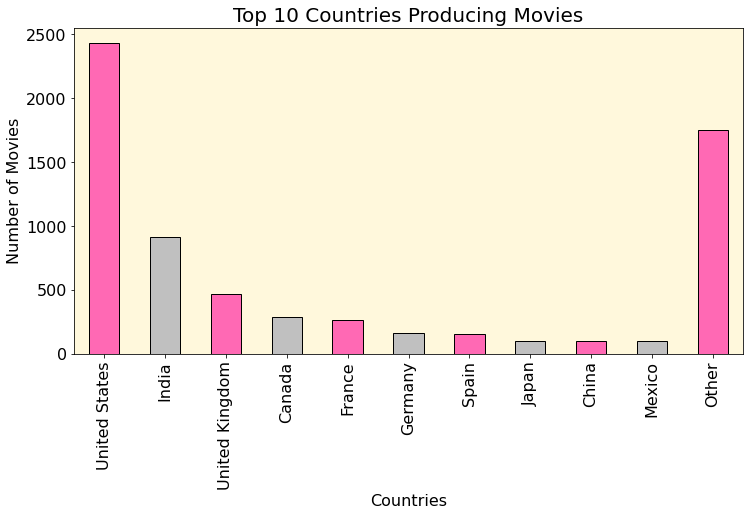

In [19]:
# Q9 What are the top 10 countries producing movies? 

def top_values_from_counts(input_counts,num_of_values,other=False,default=False,default_value=""):
    '''Takes a series and creates a series with the top number of values specified. 
    Also takes in a parameter to create an "other" to sum values not included in the top row. 
    Can also take the defult value for a column which it can add to the other column to only return valid values.'''
    if default:
        default_counts = input_counts[default_value]
        input_counts = input_counts.drop(labels = [default_value])
    else:
        default_counts = 0
    final_counts = input_counts[:num_of_values]
    if other:
        final_counts["Other"] =  input_counts[num_of_values+1:].sum() + default_counts
    return final_counts

def prep_top_values(df,column,delimiter,num_of_values,other=False,default=False,default_value=""):
    '''Call functions counts_series and top_values_from_counts to be able to create the top frequency of values for a given column.'''
    counts_s = counts_series(df,column,delimiter)
    output_s = top_values_from_counts(counts_s,num_of_values,other,default,default_value)
    return output_s

top_countries_Movies = prep_top_values(netflix_Movies,"country",",",10,other=True,default=True,default_value="Unknown")

print(top_countries_Movies)

country_colors = ["hotpink","silver"]

axes = top_countries_Movies.plot.bar(color=country_colors,edgecolor="black",figsize=(12, 6))
axes.set_ylabel("Number of Movies")
axes.set_xlabel("Countries")
axes.set_title('Top 10 Countries Producing Movies',fontsize = 20)
axes.set_facecolor("cornsilk")
None

United States     866
United Kingdom    256
Japan             184
South Korea       157
Canada            126
France             84
India              75
Taiwan             70
Australia          60
Spain              57
Other             743
dtype: int64


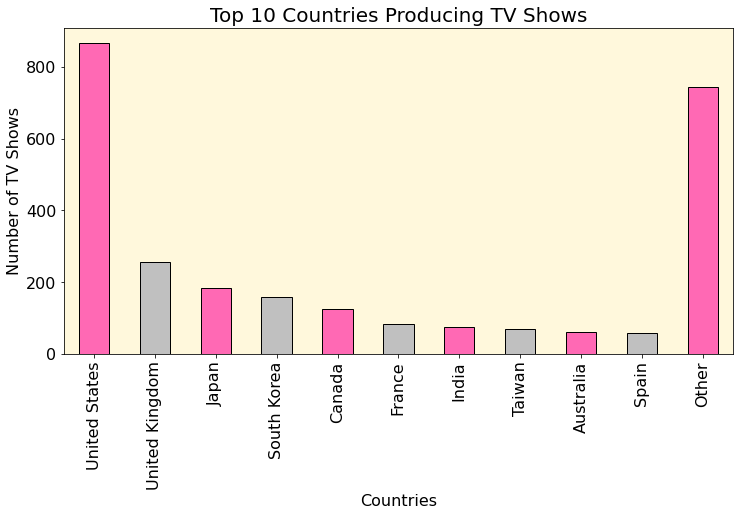

In [20]:
# Q10 What are the top 10 countries producing TV shows? 

top_countries_TV = top_countries_Movies = prep_top_values(netflix_TV,"country",",",10,other=True,default=True,default_value="Unknown")

print(top_countries_TV)

axes = top_countries_TV.plot.bar(color=country_colors,edgecolor="black",figsize=(12, 6))
axes.set_ylabel("Number of TV Shows")
axes.set_xlabel("Countries")
axes.set_facecolor("cornsilk")
axes.set_title('Top 10 Countries Producing TV Shows',fontsize = 20)
None

### The top 10 Movie producing countries are not the same as the top 10 TV Show producing countries!

**Observations**

1. The United States is the top content provider for both Movies and TV Shows. 

2. India is in the 2nd place for movies, but falls to 7th place for TV Shows. 

3. Japan is better represented in TV shows compared to movies. 

4. China, Germany and Mexico are in the top 10 countries for movies, but fall off top 10 for TV Shows.

5. Australia, South Korea and Taiwan are on the top 10 list for TV content, but are not in the top 10 for Movies.

6. United Kingdom, Canada, France and Spain are the other countries that appear in the top 10 for both lists. 

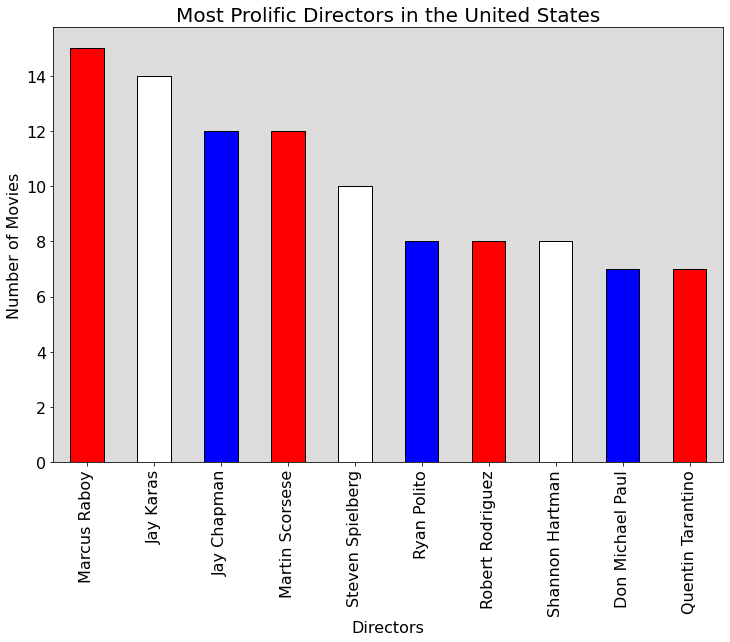

In [21]:
# Q11 Who are the top 10 most prolific directors in the United States? 

director_counts_US = Netflix_US["director"].value_counts().sort_values(ascending=False)
top_directors_US = top_values_from_counts(director_counts_US,10,False,True,"Unknown")

colors_US = ["red","white","blue"]

axes = top_directors_US.plot.bar(color=colors_US,edgecolor="black",figsize=(12, 8))
axes.set_ylabel("Number of Movies")
axes.set_xlabel("Directors")
axes.set_title('Most Prolific Directors in the United States',fontsize = 20)
axes.set_facecolor("gainsboro")
None

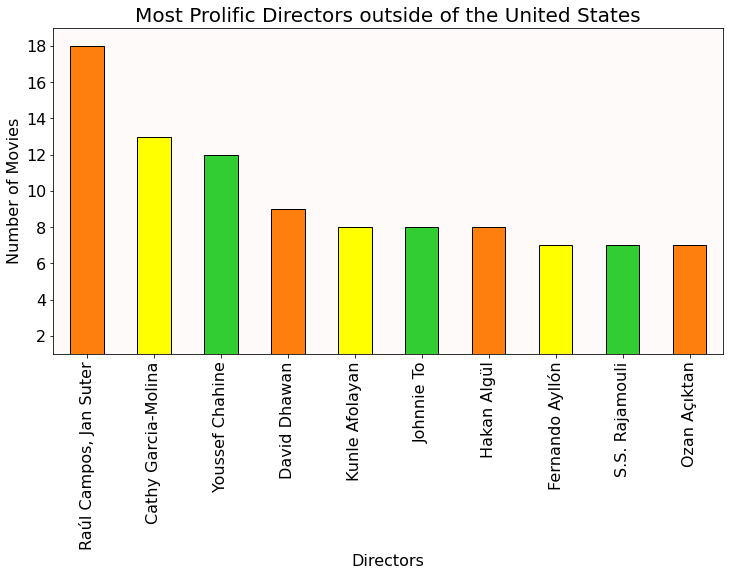

In [22]:
# Q12 Who are the top 10 most prolific directors outside of the United States? 

directors_outside_US = Netflix_outside_US["director"].value_counts().sort_values(ascending=False)
top_directors_outside_US = top_values_from_counts(directors_outside_US,10,False,True,"Unknown")

colors_world = ["tab:orange","yellow","limegreen"]

axes = top_directors_outside_US.plot.bar(color=colors_world,figsize=(12, 6),ylim=(1,19),edgecolor="black")
axes.set_ylabel("Number of Movies")
axes.set_xlabel("Directors")
axes.set_title('Most Prolific Directors outside of the United States',fontsize = 20)
axes.set_facecolor("snow")
None

In [23]:
# Q13 How does the content vary by Rating in the United States? 

#Standardizing Ratings based on #https://help.netflix.com/en/node/2064
netflix.loc[netflix["rating"] == "G","ages_appropriate"] = "Kids"
netflix.loc[netflix["rating"] == "PG","ages_appropriate"] = "Kids"
netflix.loc[netflix["rating"] == "TV-G","ages_appropriate"] = "Kids"
netflix.loc[netflix["rating"] == "TV-PG","ages_appropriate"] = "Kids"
netflix.loc[netflix["rating"] == "TV-Y","ages_appropriate"] = "Kids"
netflix.loc[netflix["rating"] == "TV-Y7","ages_appropriate"] = "Kids"
netflix.loc[netflix["rating"] == "TV-Y7-FV","ages_appropriate"] = "Kids"
netflix.loc[netflix["rating"] == "PG-13","ages_appropriate"] = "Teens"
netflix.loc[netflix["rating"] == "TV-14","ages_appropriate"] = "Teens"
netflix.loc[netflix["rating"] == "R","ages_appropriate"] = "Adults"
netflix.loc[netflix["rating"] == "TV-MA","ages_appropriate"] = "Adults"
netflix.loc[netflix["rating"] == "NC-17","ages_appropriate"] = "Adults"
netflix.loc[netflix["rating"] == "UR","ages_appropriate"] = "Not Rated"
netflix.loc[netflix["rating"] == "NR","ages_appropriate"] = "Not Rated"

def count_and_percent_of_column (df,column,new_column_name):
    '''Takes a dataframe and a column and sum the occurence and creates a percentage for the value in a new df'''
    new_df = df[column].value_counts().reset_index(name="counts")
    new_df["percent"] = (new_df["counts"] / new_df["counts"].sum() * 100).round(decimals=2)
    new_df.rename(columns={'index': new_column_name,}, inplace=True)
    return new_df

Netflix_US = filter_by(netflix,"country_primary","United States")

count_and_percent_of_column(Netflix_US,"ages_appropriate","age")

,age,counts,percent
0,Adults,1368,47.45
1,Kids,781,27.09
2,Teens,693,24.04
3,Not Rated,41,1.42


In [24]:
# Q14 How does the content vary by Rating outside the United States? 

Netflix_outside_US = exclude_by_value_contained_in(netflix,"country","United States")
count_and_percent_of_column(Netflix_outside_US,"ages_appropriate","age")

,age,counts,percent
0,Adults,1957,43.59
1,Teens,1513,33.70
2,Kids,972,21.65
3,Not Rated,48,1.07


###  There is more content for teenagers from countries other than the United States (almost 10% higher) which is reflective of the global population skewing to a lower age in highly populated countries. There is less than 50% content for adults world wide. 

In [25]:
# Q15 What are the average length of movie produced in United States and how does it compare to the rest of the world?

print("US Average Movie Length (in Minutes): ", round(Netflix_US_Movies["runtime"].mean(),2))

print("Outside US Average Movie Length (in Minutes): ",round(Netflix_outside_US_Movies["runtime"].mean(),2))

print("Worldwide Average Movie Length (in Minutes): ",round(netflix_Movies["runtime"].mean(),2))


US Average Movie Length (in Minutes):  92.36
Outside US Average Movie Length (in Minutes):  105.04
Worldwide Average Movie Length (in Minutes):  99.31


###  The average US movie is shorter than the rest of the world - by an average of over 10 minutes. With out shorter runtimes, we are bringing down the overall average movie duration by over 5 minutes!

In [26]:
# Q16 What is the longest movie? 

titles_based_on_sort_order(netflix_Movies,"runtime",1,False)["title"].iloc[0]

'Black Mirror: Bandersnatch'

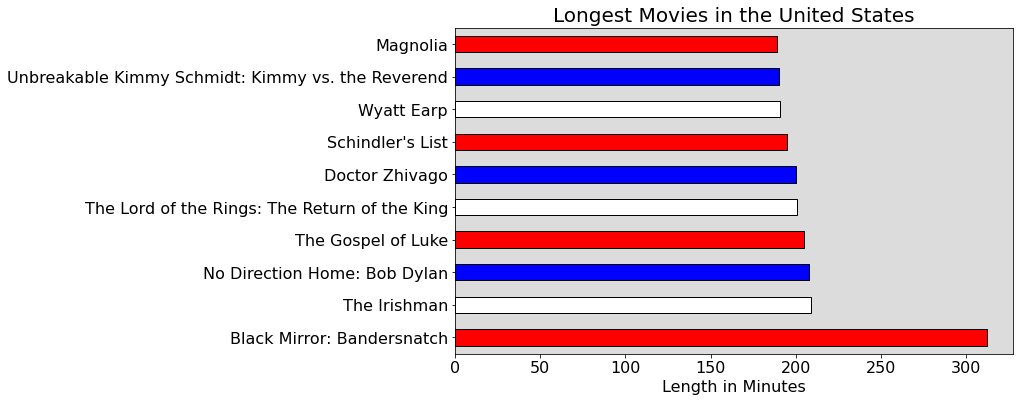

In [27]:
# Q17 What are the top 10 longest American movies?

US_longest_movies = titles_based_on_sort_order(Netflix_US_Movies,"runtime",10,False)

axes = US_longest_movies.plot.barh(x="title",y="runtime",color=colors_US,edgecolor="black",figsize=(10, 6),ylim=(0,18),legend=False)
axes.set_xlabel("Length in Minutes")
axes.set_ylabel("")
axes.set_title('Longest Movies in the United States',fontsize = 20)
axes.set_facecolor("gainsboro")
None

###  Though the average American movie is only 90 minutes long, the 10 longest movies are over double the length. Black Mirror: Bandersnatch at 312 minutes (5 hours 12 minutes) is the longest movie in the Netflix collection. 

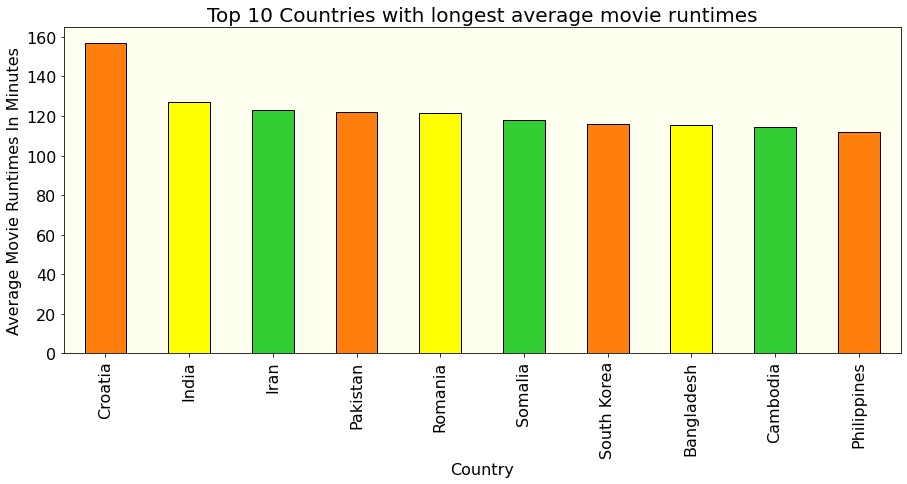

In [28]:
# Q18 What are the top 10 countries with the longest average runtime? 

movie_high_avg_runtime = round(netflix_Movies.groupby(["country_primary"])["runtime"].mean(),2).reset_index(name="avg").sort_values("avg",ascending=False)[:10].reset_index(drop=True)
#Basing the runtime on the primary listed country. 

axes = movie_high_avg_runtime.plot.bar(x="country_primary",y="avg",color=colors_world,edgecolor="black",figsize=(15, 6),legend=False)
axes.set_xlabel("Country")
axes.set_ylabel("Average Movie Runtimes In Minutes")
axes.set_title("Top 10 Countries with longest average movie runtimes",fontsize = 20)
axes.set_facecolor("ivory")
None

###  Surprise! The average runtime of a movie from Croatia is even longer than the average Bollywood movie! 

#### What's Bollywood? I'm glad you asked! Bollywood derived from Hollywood and Bombay refers to the Hindi language film industry made in a city formery know as Bombay. It's a major content provider in the world of films. It is also worth noting that while all Bollywood films are Indian films, not all Indian films are Bollywood films. India also produces films in other languages across different regions and Netflix carriers a decent sized collection of all of them. 

### However, there is only 1 movie from Croatia so that's not a good sample size. Let's look at the next country - India.

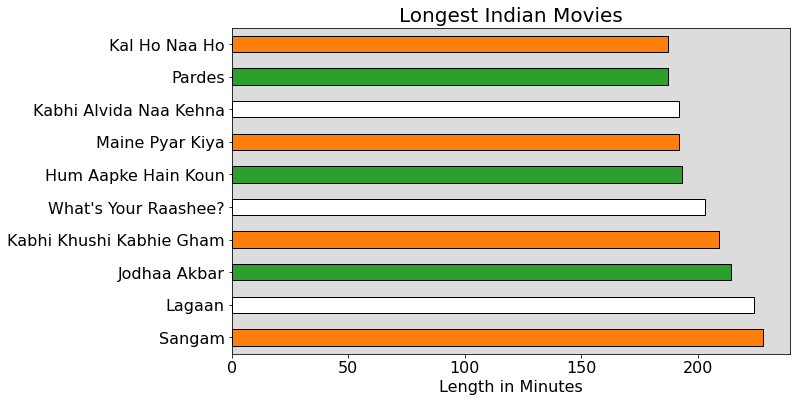

In [29]:
# Q19 What are the top 10 longest Indian movies?

India_longest_movies = titles_based_on_sort_order(India_Movies,"runtime",10,False)

colors_India = ["tab:orange","white","tab:green"]

axes = India_longest_movies.plot.barh(x="title",y="runtime",color=colors_India,edgecolor="black",figsize=(10, 6),ylim=(0,18),legend=False)
axes.set_xlabel("Length in Minutes")
axes.set_ylabel("")
axes.set_title('Longest Indian Movies',fontsize = 20)
axes.set_facecolor("gainsboro")
None

### As I suspected -- These are all Bollywood films! 

In [30]:
# Q20 What are the top 10 longest movie titles?

def longest_or_shortest_titles(df,num_titles,shortest=False):
    '''Takes a dataframe and returns a dataframe of with the number of titles and title lengths specified either by longest or shortest'''
    df_size = df[["title"]] 
    df_size = df_size.copy()
    df_size["title_length"] = df_size["title"].str.len()
    return titles_based_on_sort_order(df_size,"title_length",num_titles,shortest)[["title","title_length"]]

pd.set_option('display.max_colwidth', None)

longest_or_shortest_titles(netflix_Movies,10,False)

,title,title_length
0,"Jim & Andy: The Great Beyond - Featuring a Very Special, Contractually Obligated Mention of Tony Clifton",104
1,Mike Birbiglia: What I Should Have Said Was Nothing: Tales from My Secret Public Journal,88
2,The Power of Grayskull: The Definitive History of He-Man and the Masters of the Universe,88
3,Steve Martin and Martin Short: An Evening You Will Forget for the Rest of Your Life,83
4,Cultivating the Seas: History and Future of the Full-Cycle Cultured Kindai Tuna,79
5,"Power Rangers Samurai: Christmas Together, Friends Forever (Christmas Special)",78
6,Willy and the Guardians of the Lake: Tales from the Lakeside Winter Adventure,77
7,Ya no estoy aquí: Una conversación entre Guillermo del Toro y Alfonso Cuarón,76
8,The Road to El Camino: Behind the Scenes of El Camino: A Breaking Bad Movie,75
9,Green White Green (And All the Beautiful Colours in My Mosaic of Madness),73


In [31]:
# Q21 What are the top 3 shortest movie titles in the United States?

longest_or_shortest_titles(Netflix_US_Movies,3,True)

,title,title_length
0,9,1
1,21,2
2,XX,2


### What's in a name? That which we call a rose, would only be 4 characters long...

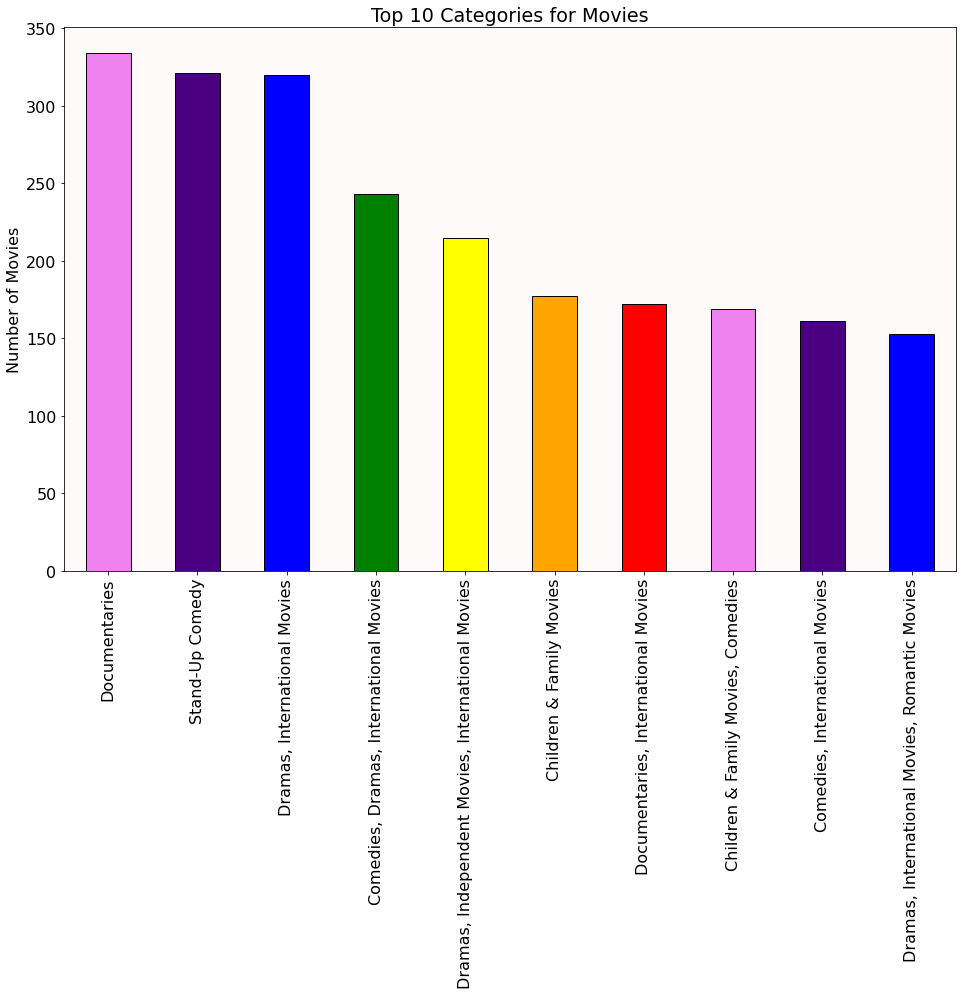

In [32]:
# Q22 What are the top 10 categories that movies are listed in?

colors_rainbow = ["violet","indigo","blue","green","yellow","orange","red"]

netflix_movie_category = netflix_Movies["listed_in"].value_counts()[:10]

axes = netflix_movie_category.plot.bar(color=colors_rainbow,edgecolor="black",figsize=(16, 10))
axes.set_ylabel("Number of Movies")
axes.set_xlabel("")
axes.set_title("Top 10 Categories for Movies")
axes.set_xticklabels(list(netflix_movie_category.index), rotation = 90)
axes.set_facecolor("snow")
None


### The first step here is to look at the how the how the movies are listed. It appears that Documentaries and Stand Ups would be the most popular categories. But to get a better representation of the genres, we need to split up the multiple values.  Also, I wouldn't classify "Stand Ups" as "movies", but that is how Netflix has categorized them.

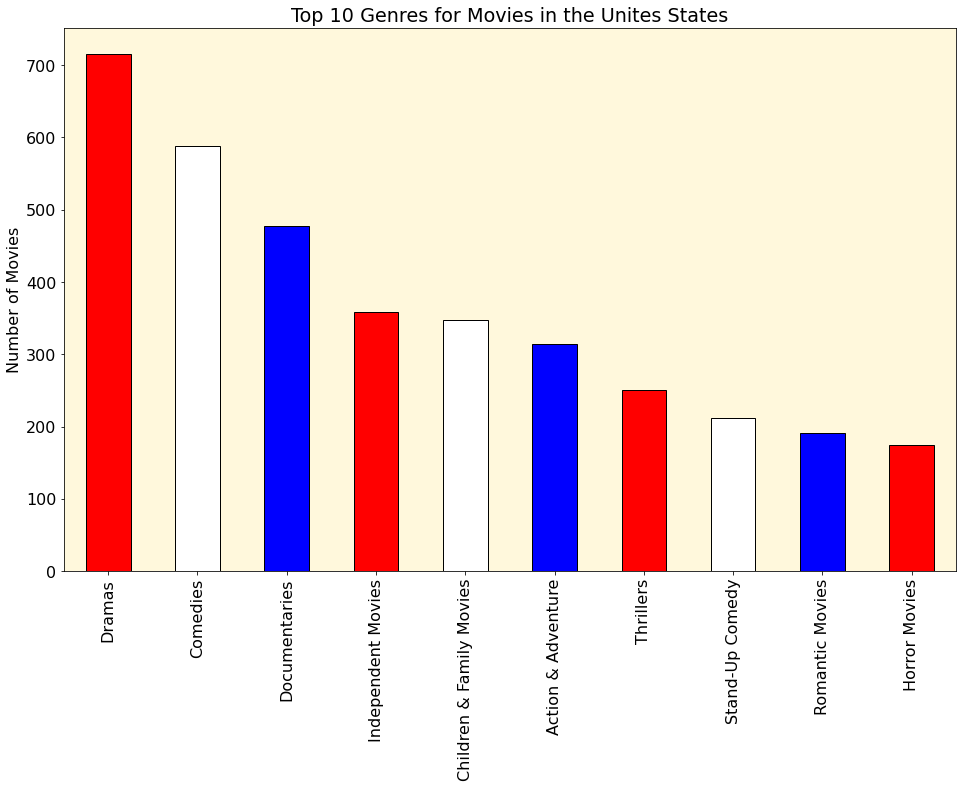

In [33]:
# Q23 What are the top 10 genres for movies in Netflix? Let's look at movies from the US. 

movie_genres_US_top_10 = prep_top_values(Netflix_US_Movies,"listed_in",",",10)

axes = movie_genres_US_top_10.plot.bar(color=colors_US,edgecolor="black",figsize=(16, 10))
axes.set_ylabel("Number of Movies")
axes.set_xlabel("")
axes.set_title("Top 10 Genres for Movies in the Unites States")
axes.set_xticklabels(list(movie_genres_US_top_10.index), rotation = 90)
axes.set_facecolor("cornsilk")
None

### Now we can see that there are more Dramas and Comedies overall compared to Documentaries and Stand-Ups. This is looking at values in the United States only.

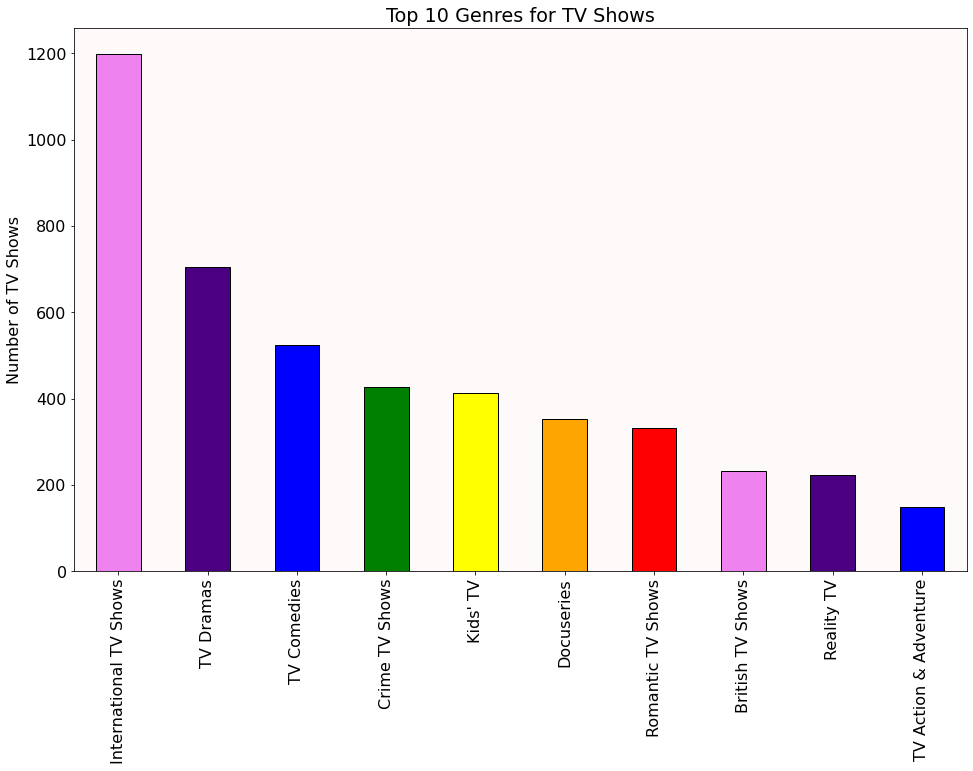

In [34]:
# Q24 What are the top 10 genres for TV shows in Netflix? 

TV_genres_top_10 = prep_top_values(netflix_TV,"listed_in",",",10)

axes = TV_genres_top_10.plot.bar(color=colors_rainbow,edgecolor="black",figsize=(16, 10))
axes.set_ylabel("Number of TV Shows")
axes.set_xlabel("")
axes.set_title("Top 10 Genres for TV Shows")
axes.set_xticklabels(list(TV_genres_top_10.index), rotation = 90)
axes.set_facecolor("snow")
None

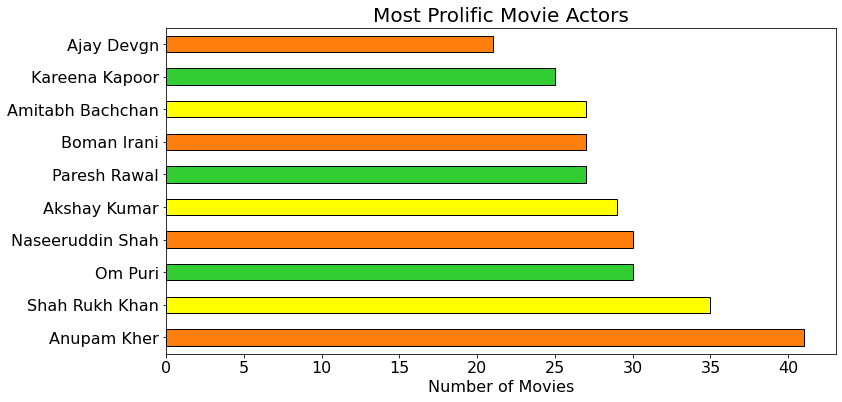

In [35]:
# Q25 Who are the top most prolific movie actors in Netflix?

#prolific_movie_actor_world = prep_top_values(netflix_Movies,"cast",",",10,other=False,default=True,default_value="Unknown")

movie_actor_world = counts_series(netflix_Movies,"cast",",")
prolific_movie_actor_world = top_values_from_counts(movie_actor_world,10,other=False,default=True,default_value="Unknown")

axes = prolific_movie_actor_world.plot.barh(x="title",y="runtime",color=colors_world,edgecolor="black",figsize=(12, 6),legend=False)
axes.set_xlabel("Number of Movies")
axes.set_ylabel("")
axes.set_title('Most Prolific Movie Actors',fontsize = 20)
None


### They are all Bollywood actors! Bollywood makes a lot of movies!

**Anupam Kher has acted in over 500 films including some English language films such as The Big Sick. **

**Shahrukh Khan (image below) is a popular Indian actor who is heralded as one of the richest actors in the world with an estimated net worth of over 600 million USD. Basically in the time it took me to do this project, he probably made several million dollars. **

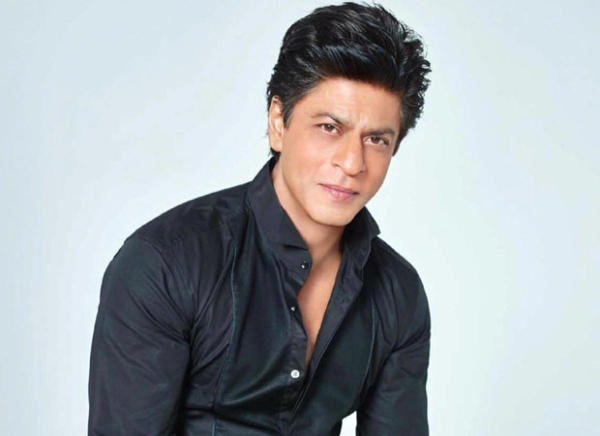

Adam Sandler         19
James Franco         18
Samuel L. Jackson    18
Nicolas Cage         17
Tara Strong          14
Johnny Depp          14
Fred Tatasciore      14
Alfred Molina        13
Molly Shannon        13
Danny Trejo          13
dtype: int64


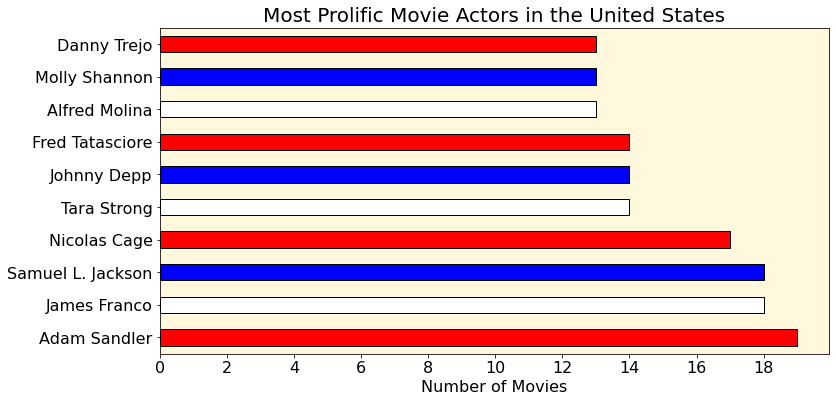

In [36]:
# Q26 Who are the most prolific actors in the United States?

movie_actor_US = counts_series(Netflix_US_Movies,"cast",",")

prolific_movie_actor_US = top_values_from_counts(movie_actor_US,10,other=False,default=True,default_value="Unknown")

print(prolific_movie_actor_US)
axes = prolific_movie_actor_US.plot.barh(x="title",y="runtime",color=colors_US,edgecolor="black",figsize=(12, 6),legend=False)
axes.set_xlabel("Number of Movies")
axes.set_ylabel("")
axes.set_xticks(range(0,20,2))
axes.set_title('Most Prolific Movie Actors in the United States',fontsize = 20)
axes.set_facecolor("cornsilk")
None


In [37]:
# Q27 How many actors have represented in the Netflix content selection? 

overall_cast = counts_series(netflix,"cast",",")
US_cast = counts_series(Netflix_US,"cast",",")

def return_len(input):
    '''Returns the length'''
    return len(input)

def return_than_num(input_series, num_values):
    '''Takes a series and returns a count of number of key values having a nummber greater than specified'''
    return (input_series > num_values).value_counts()[1]

def rounded_percent(num,den):
    '''Calculates a percent given the numerator and denominator and rounds to 2 decimal places'''
    return round(num/den * 100,2)

overall_cast_num = return_len(overall_cast)
overall_cast_num_high = return_than_num(overall_cast,4)
overall_cast_ratio_of_high = rounded_percent(overall_cast_num_high,overall_cast_num)

US_cast_num = return_len(US_cast)
US_cast_num_high = return_than_num(US_cast,4)
US_cast_ratio_of_high = rounded_percent(US_cast_num_high,US_cast_num)

print("(Worldwide) Total Number of Actors: ", overall_cast_num)
print("(Worldwide) Total Number of Actors who have appeared in at least 5 titles: ", overall_cast_num_high)
print("(Worldwide) Ratio of cast members with at least 5 titles to all: ", str(overall_cast_ratio_of_high),"\n")

print("(US) Total Number of Actors: ", US_cast_num)
print("(US) Total Number of Actors who have appeared in at least 5 titles: ", US_cast_num_high)
print("(US) Ratio of cast members with at least 5 titles to all: ", str(US_cast_ratio_of_high),"\n")

print("Percent of cast members in US movies: ", str(rounded_percent(US_cast_num,overall_cast_num)))

print("Percent of content in US: ", str(rounded_percent(return_len(Netflix_US),return_len(netflix))))

(Worldwide) Total Number of Actors:  32882
(Worldwide) Total Number of Actors who have appeared in at least 5 titles:  1728
(Worldwide) Ratio of cast members with at least 5 titles to all:  5.26 

(US) Total Number of Actors:  11997
(US) Total Number of Actors who have appeared in at least 5 titles:  633
(US) Ratio of cast members with at least 5 titles to all:  5.28 

Percent of cast members in US movies:  36.49
Percent of content in US:  37.02


### Netflix showcases the talent of 32882 individual cast members all over the world! 

### The US makes up less than 40% of the content and cast. That means a majority of the data and actors are international, making Netflix a truly global platform!